In [ ]:
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Conv2DTranspose, Conv2D, Activation, Reshape, Dropout, Flatten
import pandas as pd
import time
import os
from IPython import display
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # shift to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def g_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def d_loss(real_output, fake_output):
    real_l = cross_entropy(tf.ones_like(real_output), real_output)
    fake_l = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_l = real_l + fake_l
    return total_l

In [ ]:
g_optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4, beta_1 = 0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4, beta_1 = 0.5)

In [ ]:
@tf.function
def train_step(images, generator, discriminator):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = g_loss(fake_output)
      disc_loss = d_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  if (epoch==1) or (epoch%10==0):
    plt.savefig('Model14_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset, epochs, generator, discriminator):
  for epoch in range(epochs):
    start = time.time()
    loss_train = []
    for image_batch in dataset:
      loss_train.append(train_step(image_batch, generator, discriminator))
    train_loss.loc[len(train_loss)] = np.mean(loss_train, axis=0)
    with gen_summary_writer.as_default():
        tf.summary.scalar('g_loss', train_loss.gen_loss.values[-1], step=epoch)
    with disc_summary_writer.as_default():
        tf.summary.scalar('d_loss', train_loss.disc_loss.values[-1], step=epoch)
    if (epoch==1) or (epoch%10==0):
        generate_and_save_images(generator, epoch, seed)
  generate_and_save_images(generator,epochs,seed)
  return 

In [ ]:
def make_generator():
  model = tf.keras.Sequential()
  model.add(Dense(128, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Dense(7*7*128))
  model.add(BatchNormalization())
  model.add(Reshape((7, 7, 128)))

  model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

  assert model.output_shape == (None, 28, 28, 1)

  return model

In [ ]:
def make_discriminator():
  model = tf.keras.Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(1024))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Dense(256))
  model.add(LeakyReLU())

  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
generator = make_generator()
discriminator = make_discriminator()

In [ ]:
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

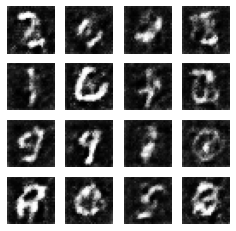

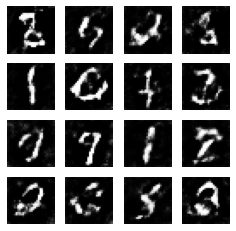

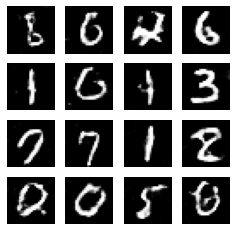

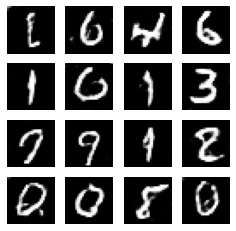

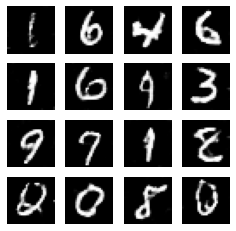

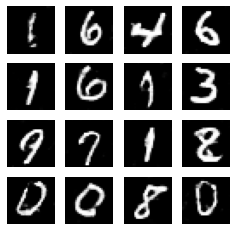

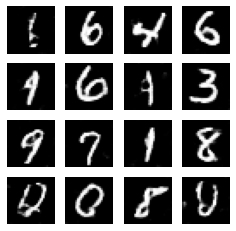

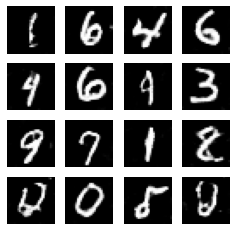

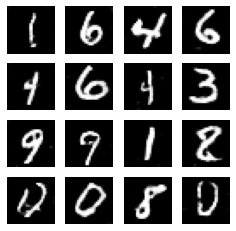

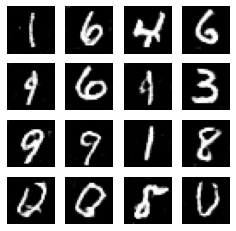

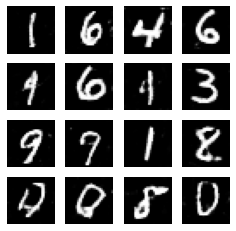

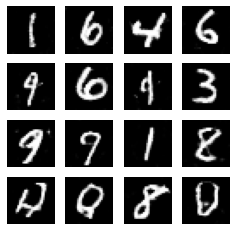

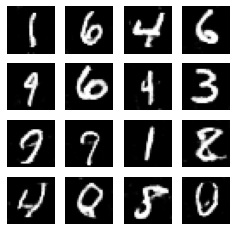

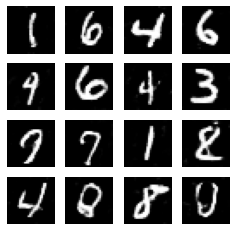

In [ ]:
gen_log_dir = 'logs/gradient_tape/GAN_gen'
disc_log_dir = 'logs/gradient_tape/GAN_disc'
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)
model_='model'
train(train_dataset, 300, generator, discriminator)

In [ ]:
# generator.save('/content/drive/My Drive/Colab Notebooks/Advanced_ML/Model14/'+'model.h5')
# train_loss.to_csv('/content/drive/My Drive/Colab Notebooks/Advanced_ML/Model14/loss.csv')

In [ ]:
%tensorboard --logdir {gen_log_dir}

In [ ]:
%tensorboard --logdir {disc_log_dir}